In [1]:
import sys
from inverse_search import gates_set_generator, matrix_list, add_inverse_gates
from NTU_simulation_hardware import NTU_processor
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gates_set = gates_set_generator(1)

In [3]:
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip import (sigmax, sigmay, tensor)

import functools # for reduce
from qutip.qip.operations.gates import *
from qutip import basis
from qutip_qip.circuit import QubitCircuit
from qutip.metrics import fidelity
from qutip.qip.noise import RandomNoise

In [4]:
from qutip.solver import Options

In [5]:
VStd = 0.1
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 10e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

# Decoherence time
T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

In [6]:
class NTU_compiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.pulse_discretization_compiler,
            "RY": self.pulse_discretization_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), phase[0] * coeff),
            ("sy" + str(gate.targets[0]), phase[1] * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def pulse_discretization_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        if gate.name == "RX":
            phiNaught = 0
        elif gate.name == "RY":
            phiNaught = np.pi/2
        
        VNaught = self.params["VNaught"]
        VStd = self.params["VStd"]
        phaseStd = self.params["phaseStd"]
        omega = self.params["omega"]
        aNaught = self.params["aNaught"]
        detuningStd = self.params["detuningStd"]

        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)

        _step_list = np.linspace(0,1,11) # a time step list so that the noise work
        coupling_time_series = np.abs(gate.arg_value) / (V*omega) * _step_list
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * _step_list[:-1])
        #FPGA_voltage = V * omega * np.sign(gate.arg_value) * s
        FPGA_voltage = V * omega * np.sign(gate.arg_value) * (_step_list[:-1]*0 + 1)
        #dwt = np.random.normal(scale=0.1) * coupling_time_series[:-1]
        dwt = np.random.normal(scale=detuningStd) * coupling_time_series[:-1]
        phase = [- I * np.cos(dwt) + Q * np.sin(dwt),
                 I * np.sin (dwt) - Q *np.cos(dwt)]
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=phase)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=phase)

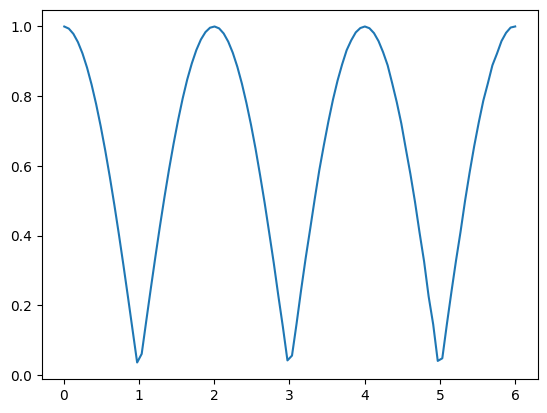

In [7]:
num_qubits =1
fidelity_list = []
index_list = []

for x in np.linspace(0.01,6,100):
    myprocessor = NTU_processor(num_qubits)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = NTU_compiler(num_qubits,{"VNaught": VNaught, "VStd": VStd, "phaseStd":phaseStd,
                                             "omega": omega, "aNaught": aNaught, "detuningStd": detuningStd,
                                             "pulse_amplitude": 20e6})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    circuit.add_gate("RY", targets=0, arg_value=x*np.pi)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])

    fidelity_list.append(final_fidelity)
    index_list.append(x)

plt.plot(index_list,fidelity_list)

In [8]:
from scipy.signal import argrelextrema
maximum_array = argrelextrema(np.asarray(fidelity_list), np.greater,order = 10)
first_max = maximum_array[0][0]
pulse_coeff = index_list[first_max]/2
if np.round(pulse_coeff,2) != 1:
    gates_set = gates_set_generator(pulse_coeff)
    print('Change pulse coeff = ' + str(pulse_coeff))
else:
    print('Pulse coeff unchanged = ' + str(pulse_coeff))

Pulse coeff unchanged = 1.0033333333333332


In [9]:
from scipy.signal import argrelextrema
def single_NTU_simulation(num_gates, gates_set, t1 = None, t2 = None, num_qubits = 1, add_FPGA_noise = True):
    """
    A single simulation, with num_gates representing the number of rotations.
    
    Args:
        num_gates (int): The number of random gates to add in the simulation.
        t1, t2 (float): Decoherence time of the qubits.
        add_FPGA_noise (bool): Whether to add in gaussian FPGA noise to the simulation.

    Returns:
        final_fidelity (float):
            Fidelity of the result state (obtained from 
            mesolve solver method) and the initial state.
    """

    # Finding the normalizing coefficient for the gate (ie finding x so that cos(x*2np.pi) = 1)

    # The actual simulation
    myprocessor = NTU_processor(num_qubits, t1 = t1, t2 = t2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = NTU_compiler(num_qubits,{"VNaught": VNaught, "VStd": VStd, "phaseStd":phaseStd,
                                             "omega": omega, "aNaught": aNaught, "detuningStd": detuningStd,
                                             "pulse_amplitude": 20e6})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford, init_state, circuit = circuit, gates_set = gates_set)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # FPGA gaussian noise
    if add_FPGA_noise == True:
        FPGA_noise = RandomNoise(dt=1e-9, indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
        myprocessor.add_noise(FPGA_noise)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity

def simulation_test_run(num_gates_list, num_sample, add_FPGA_noise = True, t1 = None, t2 = None):
    fidelity_list = []
    for x in np.linspace(0.01,6,100):
        myprocessor = NTU_processor(num_qubits)
        myprocessor.native_gates = None  # Remove the native gates
        mycompiler = NTU_compiler(num_qubits,{"VNaught": VNaught, "VStd": VStd, "phaseStd":phaseStd,
                                             "omega": omega, "aNaught": aNaught, "detuningStd": detuningStd,
                                             "pulse_amplitude": 20e6})

        # Ground state for n qubits
        init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

        # Define a random circuit.
        circuit = QubitCircuit(num_qubits)
        circuit.add_gate("RY", targets=0, arg_value=x*np.pi)

        # Simulate the circuit.
        myprocessor.load_circuit(circuit, compiler=mycompiler)
        
        # Compute results of the run using a solver of choice
        result = myprocessor.run_state(init_state, solver="mesolve")
        # Measured fidelity at the end
        final_fidelity = fidelity(result.states[0],result.states[-1])
        fidelity_list.append(final_fidelity)
        
    maximum_array = argrelextrema(np.asarray(fidelity_list), np.greater,order = 10)
    first_max = maximum_array[0][0]
    pulse_coeff = index_list[first_max]/2
    if np.round(pulse_coeff,2) != 1:
        gates_set = gates_set_generator(pulse_coeff)
    else:
        gates_set = gates_set_generator(1)
    
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [single_NTU_simulation(
            num_gates, t1 = t1, t2 = t2, add_FPGA_noise = add_FPGA_noise,
            gates_set = gates_set
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error


In [10]:
# For num_sample = 20, takes about 5 min
num_sample = 10
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,20)

In [11]:
fidelity_baseline, error_baseline = simulation_test_run(
    num_qubits, num_gates_list, num_sample, 
    t1 = None, t2 = None,
    add_FPGA_noise = False,)
fidelity_t1t2, error_t1t2 = simulation_test_run(
    num_qubits, num_gates_list, num_sample, 
    t1 = T1, t2 = T2, add_FPGA_noise = False,)
fidelity_FPGA, error_FPGA = simulation_test_run(
    num_qubits, num_gates_list, num_sample, 
    t1 = None, t2 = None, add_FPGA_noise = True, )
fidelity_FPGA_t1t2, error_FPGA_t1t2 = simulation_test_run(
    num_qubits, num_gates_list, num_sample, 
    t1 = T1, t2 = T2, add_FPGA_noise = True,)

Text(0, 0.5, 'Ground State Fidelity')

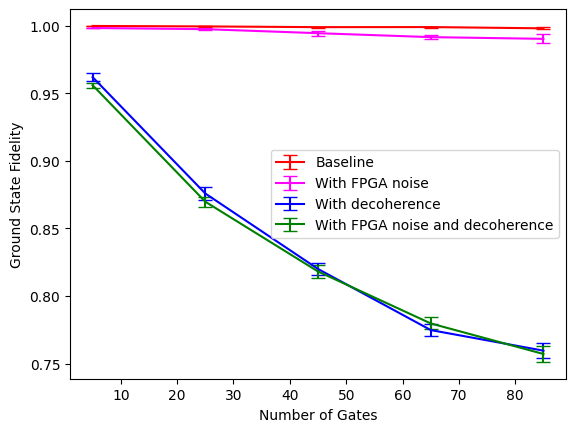

In [12]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")